In [1]:
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from tqdm import tqdm
from functions import MODEL
#import prettytable

from collections import Counter
#from prettytable import PrettyTable
from IPython.display import Image

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.regularizers import l2
from keras.constraints import max_norm
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Dropout, Flatten, Activation, Concatenate, Layer
from keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
from keras.layers import Embedding, Bidirectional, GlobalMaxPooling1D, LSTM, CuDNNLSTM
import keras.backend as K

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

obj = MODEL()

Using TensorFlow backend.


In [2]:
DTI_index=pd.read_csv('data/DTI_index.csv')[['target','drug','IC50','unit','activity','target_uniprot']]
target_seq=pd.read_csv('data/target_seq.csv')[['target_uniprot','target_chembl','seq']]
drug_smiles=pd.read_csv('data/drug_smiles.csv')[['drug','smile','seq_char_count']]

In [5]:
fset_drugs = pd.read_csv('data/fset_KIBA_drugs.csv')
fset_drugs = fset_drugs.loc[:, fset_drugs.columns != 'Unnamed: 0']
fset_drugs = fset_drugs[~fset_drugs.duplicated()]

In [12]:
# Add sequence to corresponding target IDs
seq_target = []
for target in tqdm(DTI_index['target_uniprot']):
    try:
        seq_target.append(target_seq[target_seq['target_uniprot']==target]['seq'].values[0])
    except:
        print(target)
P = pd.DataFrame(zip(DTI_index['target_uniprot'],seq_target), columns=['target_uniprot','seq'])

# Add sequence to corresponding target IDs
seq_drug = []
for drug in tqdm(DTI_index['drug']):
    try:
        seq_drug.append(drug_smiles[drug_smiles['drug']==drug]['smile'].values[0])
    except:
        print(target)
D = pd.DataFrame(zip(DTI_index['drug'],seq_drug), columns=['drug','seq'])

# Add descriptors to corresponding drug IDs
des_drug = np.empty((0,111))
for drug in tqdm(DTI_index['drug']):
    try:
        des_drug = np.append(des_drug,fset_drugs[fset_drugs['Drug']==drug].loc[:,fset_drugs.columns!='Drug'].values, axis=0)
    except:
        print(target)

100%|██████████| 61624/61624 [01:33<00:00, 657.03it/s]


In [13]:
P.shape, D.shape, des_drug.shape

((61624, 2), (61624, 2), (61624, 111))

In [8]:
# # Add descriptors to corresponding drug IDs
# des_drug = pd.DataFrame(columns=fset_drugs.columns)
# for drug in tqdm(DTI_index['drug']):
#     try:
#         des_drug = des_drug.append(pd.Series(fset_drugs[fset_drugs['Drug']==drug].values.tolist()[0],index=des_drug.columns), ignore_index=True)
#     except:
#         print(drug)

In [14]:
# Encode amino acides and smile characters
codes_target = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
char_dict_target = obj.create_dict(codes_target)

codes_drug = [char for char in ''.join(set(''.join(drug_smiles['smile'].values)))]
char_dict_drug = obj.create_dict(codes_drug)
print(len(char_dict_target),len(char_dict_drug))

20 43


In [47]:
encode_target = obj.integer_encoding(P, char_dict_target) 
encode_drug = obj.integer_encoding(D, char_dict_drug) 

# padding sequences
max_length = 1000
pad_target = pad_sequences(encode_target, maxlen=max_length, padding='post', truncating='post')
pad_drug = pad_sequences(encode_drug, maxlen=max_length, padding='post', truncating='post')

# One hot encoding of sequences
ohe_target = to_categorical(pad_target)
ohe_drug = to_categorical(pad_drug)
ohe_target.shape, ohe_drug.shape

((61624, 1000, 21), (61624, 1000, 44))

In [48]:
# label/integer encoding output variable: (y)
le = LabelEncoder()
y = le.fit_transform(DTI_index['activity'].tolist())
# One hot encoding of outputs
y = to_categorical(y)
y.shape

(61624, 3)

In [49]:
print(ohe_drug.shape, ohe_target.shape, des_drug.shape, y.shape)

(61624, 1000, 44) (61624, 1000, 21) (61624, 111) (61624, 3)


In [51]:
# Split indics into train/test
from sklearn.model_selection import train_test_split
indices = list(range(len(DTI_index)))
train_target, test_target, train_drug, test_drug, train_des, test_des, y_train, y_test = train_test_split(pad_target, pad_drug, des_drug, y, test_size=0.2, random_state=1)

In [52]:
print(train_target.shape, test_target.shape, train_drug.shape, test_drug.shape)

(49299, 1000) (12325, 1000) (49299, 1000) (12325, 1000)


In [53]:
# Attention class
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [54]:
# Model Architecture
input_target = Input(shape=(1000,))
emb_target = Embedding(21, 128, input_length=max_length)(input_target) 
conv_target_1 = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(emb_target)
pool_target_1 = MaxPooling1D(pool_size=2)(conv_target_1)
att_in_target = Bidirectional(CuDNNLSTM(32, kernel_regularizer=l2(0.01), return_sequences=True, recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))(pool_target_1)
att_out_target = attention()(att_in_target)
#flat_1_target = Flatten()(att_out_target)

# softmax classifier
#x_output_target = Dense(3, activation='softmax')(att_in_target)

input_drug = Input(shape=(1000,))
emb_drug = Embedding(44, 128, input_length=max_length)(input_drug) 
conv_drug_1 = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(emb_drug)
pool_drug_1 = MaxPooling1D(pool_size=2)(conv_drug_1)
att_in_drug = Bidirectional(CuDNNLSTM(32, kernel_regularizer=l2(0.01), return_sequences=True, recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))(pool_drug_1)
att_out_drug = attention()(att_in_drug)
#flat_1_drug = Flatten()(att_out_drug)

input_drug_des = Input(shape=(111,))
dense_drug_des_1 = Dense(512, activation="relu", kernel_initializer='glorot_normal')(input_drug_des)
dense_drug_des_2 = Dense(256, activation="relu", kernel_initializer='glorot_normal')(dense_drug_des_1)
#flat_drug_des = Flatten()(dense_drug_des_2)

concat = Concatenate()([att_out_target,att_out_drug, dense_drug_des_2])

dense_1 = Dense(512, activation = 'relu',kernel_initializer='glorot_normal')(concat)
#dense_1_dropout = Dropout(0.1)(dense_1)
dense_2 = Dense(256, activation = 'relu',kernel_initializer='glorot_normal')(dense_1)
dense_2_dropout = Dropout(0.2)(dense_2)
#dense_3 = Dense(512, activation = 'relu',kernel_initializer='glorot_normal')(dense_2)

# softmax classifier
x_output = Dense(3, activation='softmax')(dense_2_dropout)

model1 = Model(inputs=[input_target, input_drug, input_drug_des], outputs=x_output)
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 1000)         0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 1000, 128)    2688        input_13[0][0]                   
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 1000, 128)    5632        input_14[0][0]                   
____________________________________________________________________________________________

In [55]:
# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=30, verbose=1)
histories = []

In [56]:
history = model1.fit(
    [train_target, train_drug, train_des], y_train,
    epochs=500, batch_size=256,
    validation_split=0.2,
    callbacks=[es]
    )

 accuracy: 0.7171 - val_loss: 0.7163 - val_accuracy: 0.7023
Epoch 105/500
39439/39439 [==============================] - 19s 471us/step - loss: 0.6745 - accuracy: 0.7242 - val_loss: 0.7225 - val_accuracy: 0.6958
Epoch 106/500
39439/39439 [==============================] - 18s 468us/step - loss: 0.6738 - accuracy: 0.7250 - val_loss: 0.7475 - val_accuracy: 0.6815
Epoch 107/500
39439/39439 [==============================] - 18s 466us/step - loss: 0.6719 - accuracy: 0.7248 - val_loss: 0.7163 - val_accuracy: 0.7037
Epoch 108/500
39439/39439 [==============================] - 18s 468us/step - loss: 0.6731 - accuracy: 0.7249 - val_loss: 0.7366 - val_accuracy: 0.6887
Epoch 109/500
39439/39439 [==============================] - 18s 469us/step - loss: 0.6682 - accuracy: 0.7266 - val_loss: 0.7136 - val_accuracy: 0.7057
Epoch 110/500
39439/39439 [==============================] - 18s 467us/step - loss: 0.6645 - accuracy: 0.7292 - val_loss: 0.7284 - val_accuracy: 0.6932
Epoch 111/500
39439/39439 [=

In [ ]:
model1.save('models/drugTargetSeqOnly.h5')

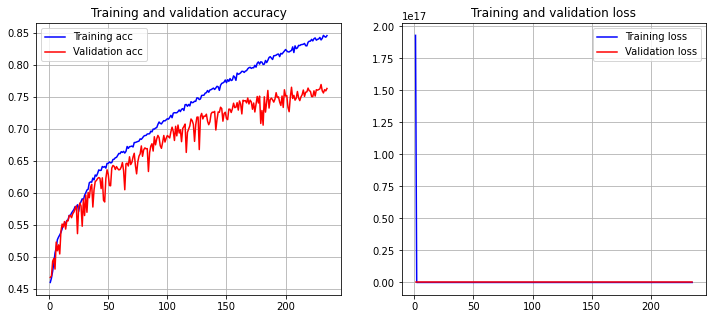

In [57]:
obj.plot_history(history)

In [58]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    y_pred_keras = model1.predict([test_target, test_drug, test_des])
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_keras[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#y_pred_keras = model1.predict([test_pad_target, test_pad_drug])
#fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

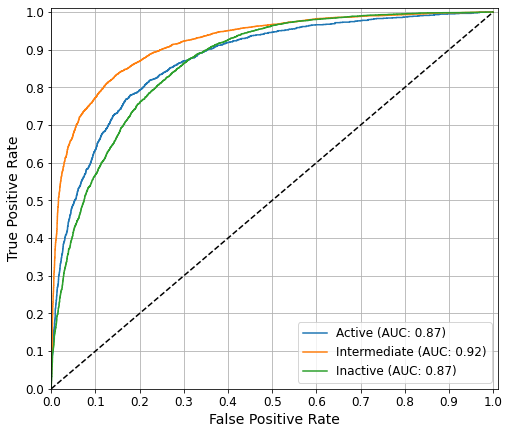

In [62]:
# Plot of a ROC curve for a specific class
fig, ax = plt.subplots(figsize=(8,7))
for i, activity in zip(range(3),['Active', 'Intermediate','Inactive']):
    ax.plot(fpr[i], tpr[i], label=activity+' (AUC: %0.2f)' % roc_auc[i], alpha=1)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_ylim([0.0, 1.01])
ax.set_xlim([0.0, 1.01])
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_xlabel('False Positive Rate', fontsize=14)
ax.set_ylabel('True Positive Rate', fontsize=14)
#ax.set_title('Receiver operating characteristic ('+train_test+')', fontsize=14)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12) 
#ax.text(0.035, 0.925, 'Average AUC:'+str(np.round(np.mean(roc_auc),3)))
ax.grid()
ax.legend(fontsize=12)
plt.savefig('plots/CD100T11/roc.png', dpi=500, bbox_inches='tight')

In [63]:
precision = dict()
recall = dict()
average_precision = dict()
#y_pred_keras = model.predict(X)[0]
for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred_keras[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_pred_keras[:, i])

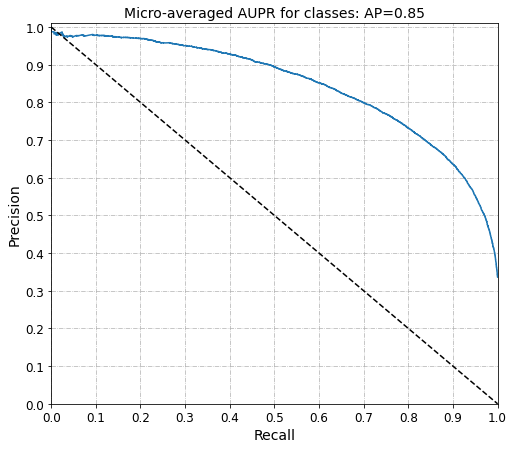

In [64]:
# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(), y_pred_keras.ravel())
average_precision["micro"] = average_precision_score(y_test, y_pred_keras, average="micro")
#print('Average precision score , micro-averaged over all classes: {0:0.2f}'
#    .format(average_precision["micro"]))

fig, ax = plt.subplots(figsize=(8,7))
ax.step(recall['micro'], precision['micro'], where='post')

ax.set_xlabel('Recall', fontsize=14)
ax.set_ylabel('Precision', fontsize=14)
ax.plot([0, 1], [1, 0], 'k--')
ax.set_ylim([0.0, 1.01])
ax.set_xlim([0.0, 1.00])
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_title(
    'Micro-averaged AUPR for classes: AP={0:0.2f}'
    .format(average_precision["micro"]), fontsize=14)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12) 
ax.grid(linestyle='-.', linewidth=0.7)
plt.savefig('plots/CD100T11/aupr.png', dpi=500, bbox_inches='tight')

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model1.evaluate([test_pad_target, test_pad_drug], y_test, batch_size=256)
print("test loss, test acc:", results)

In [ ]:
y_pred_test = model1.predict(X)[0]

In [ ]:
obj.plot_history(histories[0])

In [ ]:
obj.plot_history(histories[0])

In [ ]:
obj.plot_history(histories[0])

In [ ]:
for a in histories[0].history:
    print(a)